In [2]:
## Assignment 2 ##

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy
from scipy import misc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import math
import matplotlib.pyplot as plt
import pylab

In [3]:
# Reading Data from CSV Files

A = genfromtxt('adult_data.csv', delimiter=',')
B = genfromtxt('adult_data.csv', delimiter=',',dtype=str)
#np.savetxt('Resized_Images111.csv', resized_images, delimiter=',')

features = A[:,[0,2,4,10,11,12]]
labels = B[:,14]

features_scaled = preprocessing.scale(features, with_mean=False)

In [19]:
#Cleaning labels to be 1 and -1

labels[labels == ' <=50K'] = -1
labels[labels == ' <=50K.'] = -1
labels[labels == ' >50K'] = 1
labels[labels == ' >50K.'] = 1
labels=np.array(labels)
all([l==1 or l==-1 for l in labels])

/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([-1, -1, -1, ..., -1, -1,  1])

In [5]:
# Splitting Dataset into Train-Test-Validation Sets
td,test_features,tl,test_labels= train_test_split(features_scaled, labels, test_size=.1)
train_features, validated_features,train_labels, validated_labels = train_test_split(td,tl,test_size=int(.1*len(labels)))
test_labels

array([-1, -1, -1, ...,  1, -1,  1])

In [6]:
#Defining Support Vector Machine Model

def svc_train(trFeatures, trLabels,lamb,m,n,num_epochs,num_steps,num_held_out, eval_step):
    num_dimensions=trFeatures.shape[1]
    a=np.random.rand(num_dimensions)
    b=float(np.random.rand(1))
    acc=np.array([])
    mag=np.array([])
    for season in range(num_epochs):
        trFeat,valFeat,trLab,valLab=train_test_split(trFeatures,trLabels,test_size=num_held_out)
        step_size=m/(season+n)
        for cur_step in range(num_steps):
            #evaluate our current model
            if (cur_step +1) % eval_step ==0:
                pred=svc_predict((a,b),valFeat)
                acc=np.append(acc,accuracy_score(valLab,pred))
                mag=np.append(mag,np.linalg.norm(a))
            # randomly choose data point for stochastic gradient descent
            rand_index=random.choice(range(len(trFeat)))
            data_item=trFeat[rand_index]
            data_label=trLab[rand_index]
            # calculate aTxk +b
            gamma=np.dot(a,data_item)+b
            #update model based on data point
            if data_label *gamma >=1:
                a=a-step_size*lamb*a
                #statement below for clarity
                b=b
            else:
                a=a-step_size*(lamb*a - data_label*data_item)
                b=b-step_size*(-data_label)
    return (a,b),acc,mag

In [7]:
#Defining Prediction Function

def svc_predict(model,features):
    pred=np.zeros(len(features))
    a=model[0]
    b=model[1]
    for ind,x in enumerate(features):
        gamma=np.dot(a,x)+b
        if gamma>=0:
            pred[ind]=1
        else:
            pred[ind]=-1
    return pred

In [8]:
# Defining Variables

REG_CONS = [0.001, 0.01, 0.1, 1.0]
EPOCHS = 400
STEPS = 300
M = 5
N = 5000
BATCH_SIZE = 1
NUM_HELD_OUT = 200
EVAL_STEP=30

In [20]:
# Executing Model Using Defined Variables

acc_best_model=0
acc_lamb=np.zeros(len(REG_CONS))
acc_mag=[]
len_acc=0
len_mag=0
accs=[]
mags=[]
for lamb in REG_CONS:
    svc_model, acc,mag=svc_train(train_features,train_labels,lamb, M,N, EPOCHS, STEPS, NUM_HELD_OUT,EVAL_STEP)
    accs=np.append(accs,acc)
    mags=np.append(mags,mag)
    len_acc=len(acc)
    len_mags=len(mag)
    pred = svc_predict(svc_model,validated_features)
    accuracy=accuracy_score(validated_labels,pred)
    if accuracy> acc_best_model:
        best_model=(svc_model,lamb)
        acc_best_model=accuracy

final_model, final_acc, final_mag =svc_train(td,tl,best_model[1], M,N,EPOCHS, STEPS, NUM_HELD_OUT,EVAL_STEP)     
test_pred = svc_predict(final_model,test_features)
test_accuracy=accuracy_score(test_labels,test_pred)

print("Best lambda value = " + str(best_model[1]))
print("Accuracy = " + str(test_accuracy))

accs.resize((len(REG_CONS),len_acc))
mags.resize((len(REG_CONS),len_acc))

Best lambda value = 0.01
Accuracy = 0.813101330604


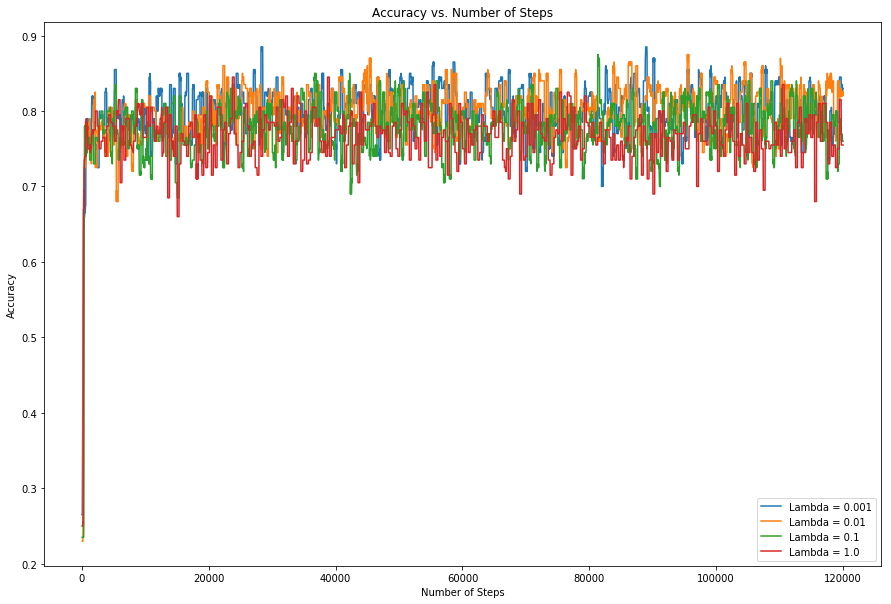

In [24]:
# Plotting Accuracies for Different Regularization Factors
stps=list(range(EVAL_STEP,EPOCHS*STEPS+1,EVAL_STEP))
plt.figure(figsize=(15,10))
for i in range(len(accs)):
    plt.plot(stps,accs[i], label = "Lambda = " + str(REG_CONS[i]))

plt.ylabel("Accuracy")
plt.xlabel("Number of Steps")
plt.title("Accuracy vs. Number of Steps")
plt.legend()
plt.savefig('Accuracy vs Number of Steps.png')

plt.show()


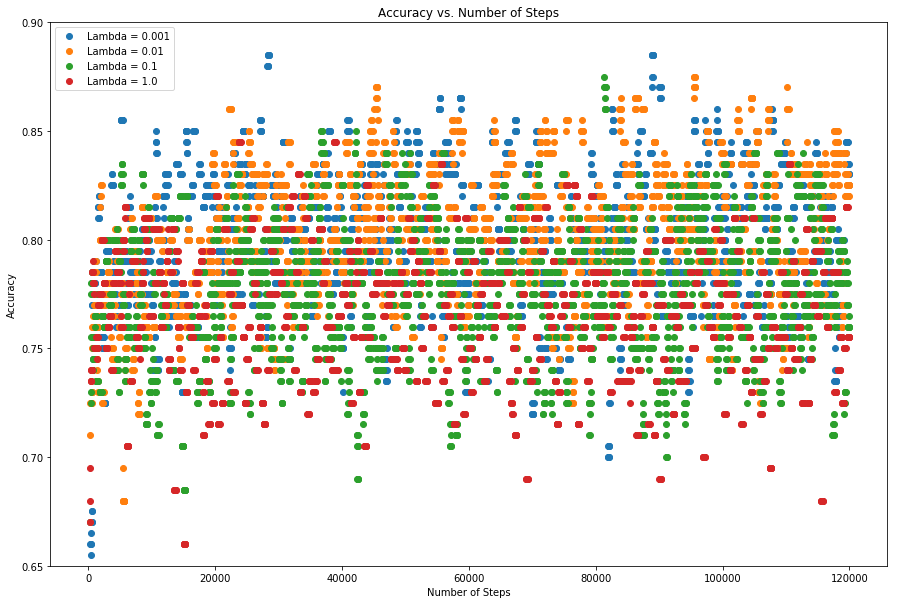

In [25]:
# Plotting Accuracies for Different Regularization Factors
stps=list(range(EVAL_STEP,EPOCHS*STEPS+1,EVAL_STEP))
plt.figure(figsize=(15,10))
for i in range(len(accs)):
    plt.plot(stps,accs[i],'o', label = "Lambda = " + str(REG_CONS[i]))
plt.ylim((.65,.9))
plt.ylabel("Accuracy")
plt.xlabel("Number of Steps")
plt.title("Accuracy vs. Number of Steps")
plt.legend()
plt.savefig('Accuracy vs Number of Steps(closer look).png')

plt.show()


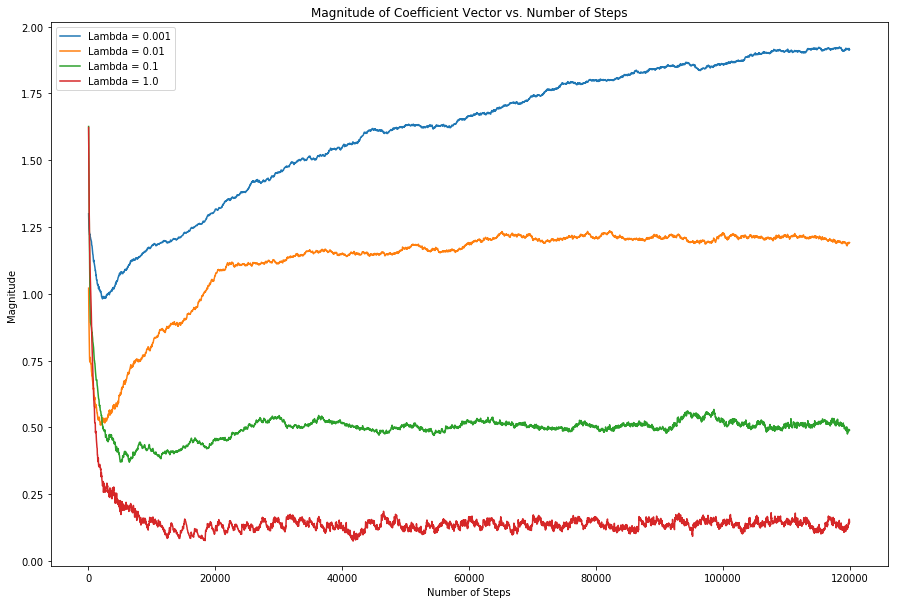

In [26]:
# Plotting Accuracies for Different Regularization Factors
plt.figure(figsize=(15,10))
for i in range(len(mags)):
    plt.plot(stps,mags[i], label = "Lambda = " + str(REG_CONS[i]))


plt.ylabel("Magnitude")
plt.xlabel("Number of Steps")
plt.legend()
plt.title("Magnitude of Coefficient Vector vs. Number of Steps")
plt.savefig('Magnitude vs Number of Steps.png')
plt.show()
